<a href="https://colab.research.google.com/github/Dau2004/Group_3_Water_Portability_formative/blob/abiodun/Abiodun_Kumuyi_Copy_of_formative_II_starter_code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Excercise - Creating our own custom Model

This is a notebook that provides a quick overview of how to create your own custom model. You will be creating a simple model.
You will be utilizing Keras and Tensorflow


## Water Quality Dataset

This dataset contains water quality measurements and assessments related to potability, which is the suitability of water for human consumption. The dataset's primary objective is to provide insights into water quality parameters and assist in determining whether the water is potable or not. Each row in the dataset represents a water sample with specific attributes, and the "Potability" column indicates whether the water is suitable for consumption.

https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability?select=water_potability.csv


## **Load and Visualize the data**

#### Load and visualizing the data to help gain insights into the structure and preprocessing requirements.

In [400]:
import pandas as pd

df = pd.read_csv('https://docs.google.com/spreadsheets/d/1H_kRGjtavba31uVjs-HILSNirokfz1R0MZa64ov4NR8/export?format=csv')
df.head()

# Count values missing per column
missing_counts = df.isna().sum()
print("\nMissing values per column:")
display(missing_counts)


Missing values per column:


,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


#### Visualize raw data using histograms, box plots, correlation heatmap, and count plot.

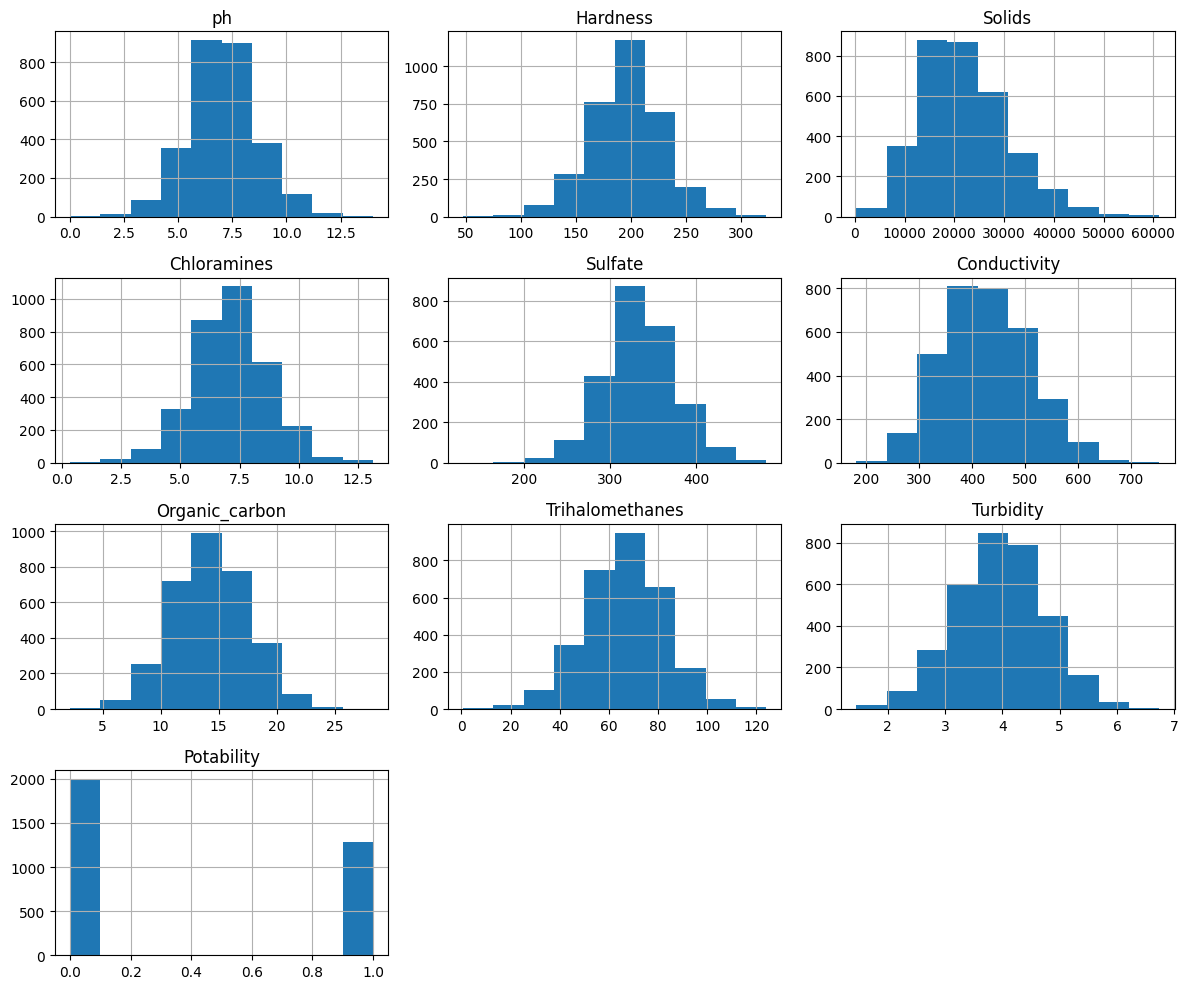

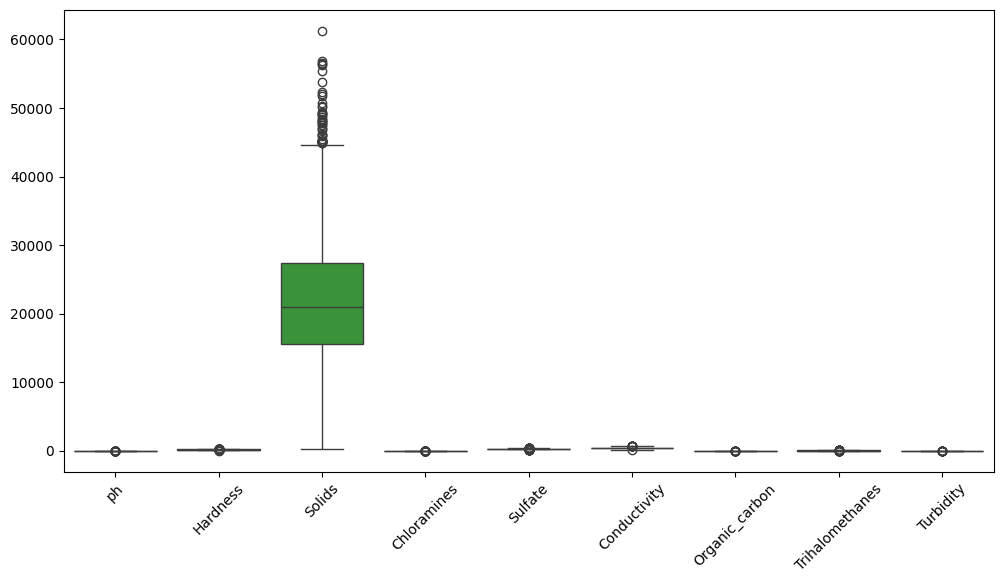

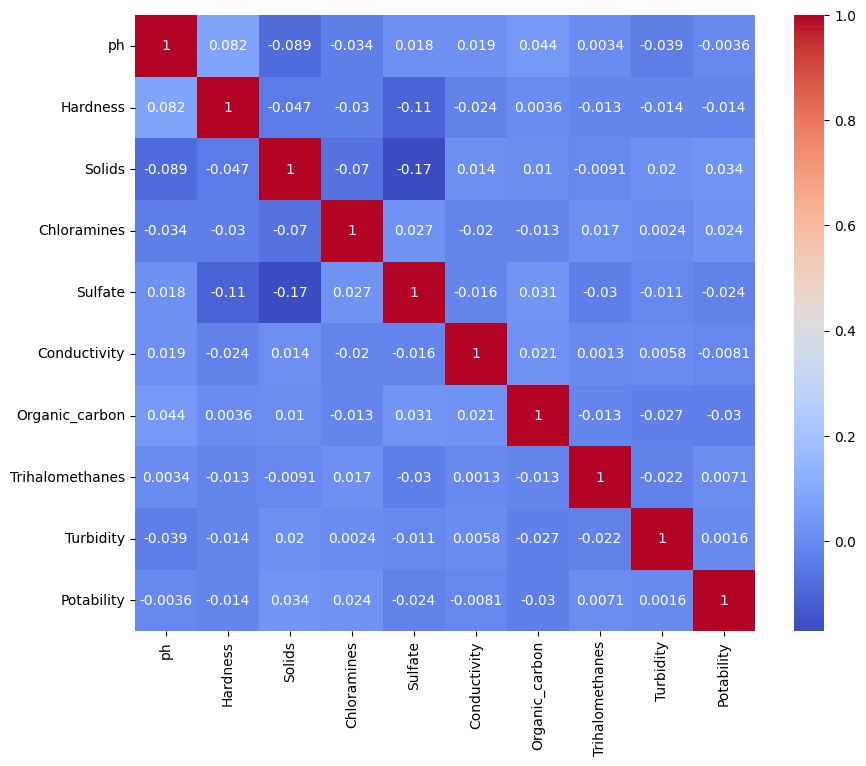

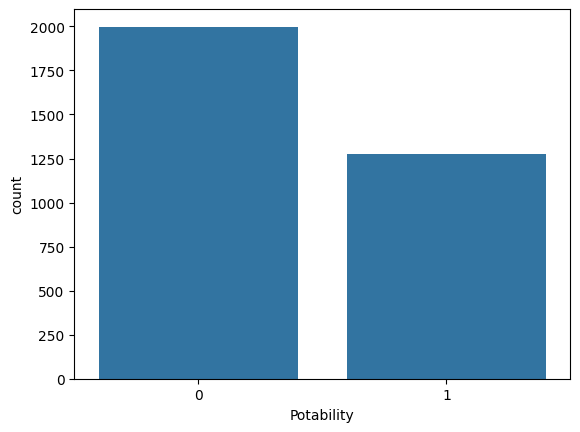

In [401]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms for each feature
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop('Potability', axis=1))
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Target distribution (Class Count)
sns.countplot(x='Potability', data=df)
plt.show()

## **Explanation of Raw Data Visualization**
### **Histograms:**
###### **Skewness:** Features like Solids, Conductivity, and Turbidity exhibit right-skewness, suggesting that transformations (e.g., log or square root) may normalize their distributions, improving the neural network performance.
###### **Outliers:** Outliers are present across all features, especially pronounced in Solids. These could skew the model unless addressed through clipping, removal, or robust scaling.
###### **Scaling:** Features have vastly different ranges (e.g., Solids up to 60,000 vs. Turbidity up to 7), necessitating standardization (e.g., StandardScaler) or robust scaling (e.g., RobustScaler) to ensure equal contribution to the model.

### **Box Plots for Outliers:**
###### **Significant Outliers:** Solids stands out with many extreme values (up to 60,000), potentially influencing the model disproportionately. Other features have fewer outliers but still require attention.
###### **Handling Option:**
#####* **Robust Scaling:** Apply RobustScaler to reduce outlier impact without removal.

### **Correlation Heatmap:**
The heatmap shows correlation coefficients between features and the target (Potability), ranging from -1 (negative) to 1 (positive).

###### **Feature-to-Feature:** Most correlations are weak (< |0.1|). The strongest is Solids vs. Sulfate (-0.17), still modest. No significant multicollinearity is present.
###### **Feature-to-Target (Potability):** Very weak correlations, ranging from -0.036 (pH) to 0.071 (Trihalomethanes). No single feature strongly predicts Potability linearly (i.e., all columns can be retained)

### **Preprocessing the data**
#### Process the raw data to handle missing values and implement insight from visulaization outcome to handle outliers.

In [402]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# For skewed features (Solids, Conductivity), apply log transformation BEFORE scaling:
df['Solids'] = np.log1p(X['Solids'])
df['Conductivity'] = np.log1p(X['Conductivity'])

imputer = IterativeImputer(random_state=42)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Separate features and target
X = df_imputed.drop('Potability', axis=1)
y = df_imputed['Potability']

# Apply Robust Scaling to handle outliers
scaler = RobustScaler()  # Instead of StandardScaler
X_scaled = scaler.fit_transform(X)

print(f"Dataset shape: {df.shape}")
print(f"Missing values before: {df.isnull().sum().sum()}")
print(f"Missing values after: {pd.DataFrame(X_scaled).isnull().sum().sum()}")

Dataset shape: (3276, 10)
Missing values before: 1434
Missing values after: 0


### Confirm RobustScaler effectively reduced the impact of outlier in Solids.

In [403]:
# Before and after comparison for Solids feature
import numpy as np

print("\nSolids feature - Before scaling:")
print(f"Min: {np.min(X['Solids']):.2f}, Median: {np.median(X['Solids']):.2f}, "
      f"Max: {np.max(X['Solids']):.2f}, IQR: {np.quantile(X['Solids'], 0.75) - np.quantile(X['Solids'], 0.25):.2f}")

# Get scaled Solids values
solids_scaled = X_scaled[:, 2]

print("\nSolids feature - After Robust Scaling:")
print(f"Min: {np.min(solids_scaled):.2f}, Median: {np.median(solids_scaled):.2f}, "
      f"Max: {np.max(solids_scaled):.2f}, IQR: {np.quantile(solids_scaled, 0.75) - np.quantile(solids_scaled, 0.25):.2f}")


Solids feature - Before scaling:
Min: 0.27, Median: 0.28, Max: 0.28, IQR: 0.00

Solids feature - After Robust Scaling:
Min: -11.10, Median: 0.00, Max: 1.78, IQR: 1.00


## **Split data into Train/Test/Validation sets**

In [404]:
# First split: training (70%) and temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Second split: validation (50% of temp) and test (50% of temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training set:   {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape},  Labels: {y_val.shape}")
print(f"Test set:       {X_test.shape},  Labels: {y_test.shape}")

Training set:   (2293, 9), Labels: (2293,)
Validation set: (491, 9),  Labels: (491,)
Test set:       (492, 9),  Labels: (492,)


# Each Memeber Defines their model Here

In [405]:
#Model Definition by Abiodun

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import L2

def model_abiodun(dropout_rate=dropout_rate):
    model = Sequential([
        Input(shape=(9,)),
        Dense(128, activation='relu', kernel_regularizer=L2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=L2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=L2(0.005)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
model = model_abiodun(dropout_rate)

In [406]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
learning_rate = 0.001
dropout_rate = 0.365

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,            # Reduce LR by 80%
        patience=10,            # Wait 10 epochs
        min_lr=1e-6,           # Minimum learning rate
        verbose=1
    )
]

# Model compilation
model = model_abiodun(dropout_rate)
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# Start the training Process

In [407]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np # Import numpy

weights = compute_class_weight('balanced', classes=np.array([0,1]), y=y_train) # Convert list to numpy array
class_weights = {0: weights[0], 1: weights[1]}

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights
)

# Save training history for comparison
model.save('model_abiodun.keras')

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - AUC: 0.5461 - Precision: 0.4211 - Recall: 0.5668 - accuracy: 0.5338 - loss: 2.0496 - val_AUC: 0.5752 - val_Precision: 0.4094 - val_Recall: 0.7238 - val_accuracy: 0.5132 - val_loss: 1.7888 - learning_rate: 0.0010
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.5232 - Precision: 0.4181 - Recall: 0.5183 - accuracy: 0.5266 - loss: 1.8949 - val_AUC: 0.5950 - val_Precision: 0.4390 - val_Recall: 0.4972 - val_accuracy: 0.5804 - val_loss: 1.6693 - learning_rate: 0.0010
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.5692 - Precision: 0.4461 - Recall: 0.5652 - accuracy: 0.5466 - loss: 1.7159 - val_AUC: 0.6140 - val_Precision: 0.4783 - val_Recall: 0.4254 - val_accuracy: 0.6171 - val_loss: 1.5624 - learning_rate: 0.0010
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5620 - Precision: 0.4538 - Recall: 0.5194 - accuracy: 0.5435 - loss: 1.6146 - val_AUC: 0.6397 - val_Precision: 0.5035 - val_Recall: 0.3923 - v

In [412]:
model.summary()

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_436 (Dense)               │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_320         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_320 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_321         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_321 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_438 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_322         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_322 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,741 (143.52 KB)

 Trainable params: 12,097 (47.25 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 24,196 (94.52 KB)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
              precision    recall  f1-score   support

 Non-Potable       0.71      0.87      0.78       307
     Potable       0.66      0.42      0.51       185

    accuracy                           0.70       492
   macro avg       0.69      0.65      0.65       492
weighted avg       0.69      0.70      0.68       492



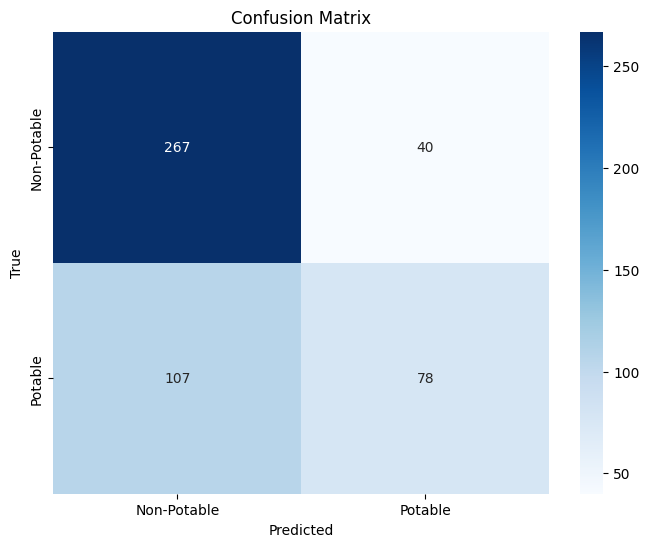

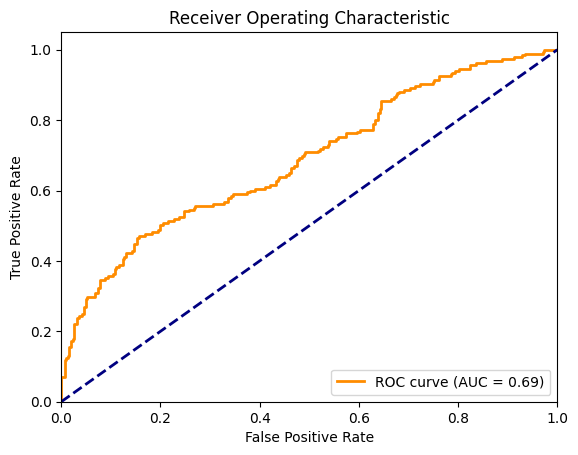

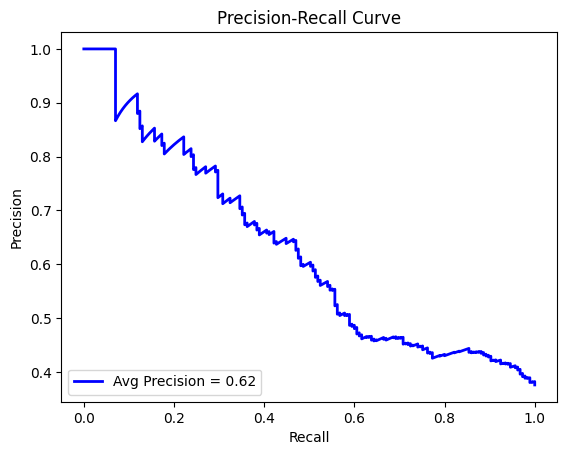


Key Performance Metrics:
          Metric     Value                                     Interpretation
0       Accuracy  0.701219                 Overall correctness - Good if >70%
1      Precision  0.694017  False positives minimization - Critical for sa...
2         Recall  0.701220  False negatives minimization - Important for w...
3       F1-Score  0.682884  Harmonic mean of precision/recall - Best singl...
4        AUC-ROC  0.688388        Model discrimination ability - Good if >0.8
5  Avg Precision  0.624480  Performance at different thresholds - Good if ...


In [413]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    average_precision_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Model Prediction
y_pred_proba = model.predict(X_test)  # Probability scores
y_pred = (y_pred_proba > 0.5).astype("int32")  # Binary predictions

# 2. Calculate Key Metrics
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
precision = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision']
recall = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
f1 = f1_score(y_test, y_pred, average='weighted')

# 3. Classification Report (Detailed)
print("="*80)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Potable', 'Potable']))
print("="*80)

# 4. Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Potable', 'Potable'],
            yticklabels=['Non-Potable', 'Potable'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', bbox_inches='tight')
plt.show()

# 6. Precision-Recall Curve (Important for imbalanced data)
precision_pts, recall_pts, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall_pts, precision_pts, color='blue', lw=2,
         label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('precision_recall_curve.png', bbox_inches='tight')
plt.show()

# 7. Metrics Summary Table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Avg Precision'],
    'Value': [accuracy, precision, recall, f1, roc_auc, avg_precision],
    'Interpretation': [
        'Overall correctness - Good if >70%',
        'False positives minimization - Critical for safety',
        'False negatives minimization - Important for water safety',
        'Harmonic mean of precision/recall - Best single metric',
        'Model discrimination ability - Good if >0.8',
        'Performance at different thresholds - Good if >0.7'
    ]
})
print("\nKey Performance Metrics:")
print(metrics_df)

# 8. Save Metrics for Comparison
metrics_df.to_csv('model_metrics.csv', index=False)

#### **Plot training history to visualize convergence**

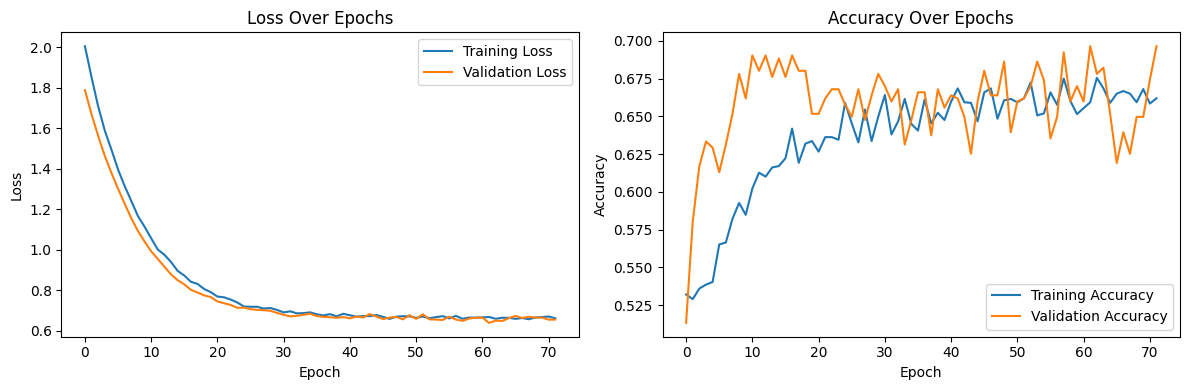

In [410]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

## **Interpretation of Metrics**

### **F1 Score:**
* **Non-Potable (0.78):** A solid F1-score, reflecting good performance in identifying non-potable water due to high recall (0.87) and decent precision (0.71). The model effectively captures most non-potable samples.
* **Potable (0.51):** A poor F1-score, driven by low recall (0.42) despite moderate precision (0.66). The model struggles to identify potable water, missing many true potable samples.
* **Weighted Average (0.68):** Falls below the "best single metric" threshold of >0.7 (as per your interpretation). The lower performance on the potable class (with fewer samples: 185 vs. 307 for non-potable) drags down the overall score, suggesting potential issues with class imbalance.

The F1-score indicates mediocre performance. While the model performs well for non-potable water, its poor performance on potable water (F1 = 0.51) is a significant concern, especially for a safety-critical application like water potability.


### **Recall:**
* **Non-Potable (0.87):** High recall means the model identifies 87% of non-potable samples correctly, which is critical for safety as it minimizes the risk of missing unsafe water.
* **Potable (0.42):** Very low recall indicates that 58% of potable samples are misclassified as non-potable. While this is less dangerous than the reverse (missing non-potable water), it still reduces the model's practical utility by rejecting safe water unnecessarily.
* **Weighted Average (0.70):** Meets the "important for water quality" threshold of >0.7, but this is heavily skewed by the non-potable class performance.

Recall is borderline acceptable. The weighted average meets the threshold, but the low recall for potable water (0.42) highlights a weakness in identifying safe water, which could impact usability.


### **Precision:**
* **Non-Potable (0.71):** When the model predicts non-potable, it is correct 71% of the time, which is reasonable.
* **Potable (0.66):** When predicting potable, it is correct only 66% of the time, meaning 34% of potable predictions are actually non-potable. This is a safety concern, as it could lead to consuming unsafe water.
* **Weighted Average (0.69):** Falls below the "critical for safety" threshold of >0.7, reflecting challenges in minimizing false positives, especially for the potable class.

Precision is suboptimal. The moderate precision for potable water (0.66) poses a safety risk due to false positives, and the weighted average not meeting the threshold further underscores this issue.


### **Loss (from Training Plots):**
The loss reduction indicates that the model learns effectively, but the final value (~0.6–0.85) corresponds to an accuracy of ~0.70, which is not exceptional for binary classification. The close alignment of training and validation losses suggests good generalization, but the plateau at a relatively high loss value indicates the model may not have reached its full potential.

### **Additional Metrics:**
* **Accuracy (0.701219):** Barely meets the "good if >70%" threshold, indicating overall correctness is acceptable but not impressive for a safety-critical task.
* **AUC-ROC (0.688388):** Below the "good if >0.8" threshold, reflecting moderate ability to distinguish between classes, as seen in ROC curves with AUC ~0.69.
* **Average Precision (0.624480):** Also below "good if >0.8", showing AP ~0.61–0.62, indicating challenges in maintaining precision at higher recall levels.


### **Confusion Matrix Insights:**
The matrix confirm the support (307 non-potable, 185 potable) and accuracy (~0.70). The model consistently excels at identifying non-potable water (high TN) but struggles with potable water (low TP, high FN), reinforcing the low recall (0.42) and moderate precision (0.66) for potable.